In [1]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt


import os
## nice defaults
# %matplotlib inline
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'xtick.labelsize': 6,
                     'ytick.labelsize': 6})
# mpl.rcParams['font.family'] = 'New Century Schoolbook'
# mpl.rcParams['font.family'] = 'Open Sans'
# mpl.rcParams['font.sans-serif'] = 'Open Sans'
# mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Verdana'] 
mpl.rcParams['text.usetex'] = False


from scipy.ndimage import gaussian_filter1d ## for plotting smoother loss


In [2]:
def systematic_resample(weights):
    """Performs the systematic resampling algorithm used by particle filters.
    This algorithm separates the sample space into N divisions. A single random
    offset is used to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.

    Parameters
    ----------
    weights : torch.Tensor
        Tensor of weights as floats
    Returns
    -------
    indexes : torch.Tensor
        Tensor of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    N = len(weights)

    # Make N subdivisions, and choose positions with a consistent random offset
    # positions = (torch.rand(1) + torch.arange(N)) / N
    positions = (torch.arange(N, device=weights.device) + torch.rand(1, device=weights.device)) / N

    # Initialize indexes array
    indexes = torch.zeros(N, dtype=torch.int64)

    # Calculate the cumulative sum of weights
    cumulative_sum = torch.cumsum(weights, dim=0)

    # Initialize pointers
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1

    return indexes

### Color palette 

In [3]:

# Earth-tone inspired colors with thematic continuity
colors = {
    "depth3_raw": "#C19A6B",  # Warm ochre (golden-brown)
    "depth3_sm": "#A67245",    # Slightly darker sienna (richer ochre)

    "depth4_raw": "#A67245",   # Carrying over sienna from depth3_sm for continuity
    "depth4_sm": "#814F2E",    # Burnt umber (deeper reddish-brown)

    "attn_raw": "#7D9FB8",     # Muted blue-gray (contrasting)
    "attn_sm": "#3B6A8C"       # Slate blue (deeper, yet harmonious)
}



#### code for magnetization from glauber dynamics


In [4]:
from torch.func import vmap
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(device)

def grab(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x

def ess(At):
    return torch.mean(torch.exp(At))**2 / torch.mean(torch.exp(2*At))


def _single_energy(cfg, J, mu, B):
    """
    Compute the energy of a single 2D Ising configuration.
    
    spins: Tensor of shape (L, L) with values in {-1, +1}
    J: coupling constant (float)
    mu: magnetic moment  (float)
    B: external field    (float) 

    Returns: energy.
    """
    L = cfg.shape[0]

    # periodic bcs, shift right on columns and down on rows
    s_right = torch.roll(cfg, shifts=-1, dims=1)
    s_down = torch.roll(cfg, shifts=-1, dims=0)

    interaction = -J * (cfg * (s_right + s_down)).sum()

    ext_field = -mu * B * cfg.sum()
    
    H = interaction + ext_field

    return H

def energy(cfgs, J, mu, B):
    return vmap(_single_energy, in_dims = (0, None, None, None), out_dims=(0))(cfgs, J, mu, B)


def absolute_mag(cfgs, L):
    """
    Compute the absolute magnetization |M| = | sum_i s_i | on a batch of configurations
    """
    return torch.mean(torch.abs(torch.sum(cfgs, dim= (1,2))) / (L*L))

def mags(cfgs, L):
    """
    Compute the magnetization M =  sum_i s_i for each configuration in a batch
    """
    return torch.sum(cfgs, dim= (1,2)) / (L*L)

def _single_step_glauber(cfg, J, mu, B , beta):
    """
    Perform a Galuber update on a single spin configuration (cfg).
    
    cfg : (L, L)
    J   : coupling constant
    beta: inverse temperature (1 / k_B T))
    
    Returns
    new_cfg:  (L, L)
    """
    
    L = cfg.shape[0]
    
    row = np.random.randint(0, L, ())
    col = np.random.randint(0, L, ())
    spins = cfg[row, col]
    
    # neighbors
    up_row = (row - 1) % L
    down_row = (row + 1) % L
    left_col = (col - 1) % L
    right_col = (col + 1) % L
    
    # local neighbor interaction
    neighbor_sum = cfg[up_row, col] + cfg[down_row, col] + cfg[row, left_col] + cfg[row, right_col]
    local_energy = J * neighbor_sum + mu * B
    delta_E = 2.0 * spins * local_energy
    
    acc = torch.exp(-beta * delta_E)
    acc = torch.minimum(acc, torch.tensor(1)) 

    
    flip =  (torch.rand(1, device=cfg.device) < acc)
    # minus or plus 1 depending on if flip is true or flase respectively
    pm1 = torch.where(flip, torch.tensor(-1.0, device=cfg.device), torch.tensor(1.0, device=cfg.device))
    cfg[row, col] = pm1 * cfg[row, col] 

    return cfg

def step_glauber(cfgs, J, mu, B, beta):
    """
    Perform a Galuber update on a batch of  spin configurations (cfgs).
    """
    bs = cfgs.shape[0]
    return vmap(_single_step_glauber, in_dims = (0, None, None, None, None),
                out_dims=(0), randomness='different')(cfgs, J, mu, B, beta)

# step_glauber(cfgs, J, mu, B , beta)



def run_glauber(bs, L, J, mu, B, beta, n_step, device = 'cpu'):
    """
    Run the Glauber dynamics for n_steps.
    
    bs: number of parallel chains (int)
    L : lattice size (int)
    """
    cfgs = torch.randint(0, 2, (bs, L, L), device=device)
    cfgs = 2*cfgs - 1  
    # print(cfgs.shape)
    
    for step in range(n_step):
        cfgs = step_glauber(cfgs, J, mu, B, beta)
        # cfgs = mcmc_step_batch(cfgs, J, mu, B, beta)
        
    return cfgs


True
cuda


In [5]:
bs_test = 15000
L_test = 15
J_test = 1.0
mu_test = 0.0
B_test = 0.0
beta_test = 0.4407
n_step_test = 50000

import time
tic = time.perf_counter()
cfgs_test_NEW = run_glauber(bs_test, L_test, J_test, mu_test, B_test, beta_test, n_step_test, device = 'cpu')
toc = time.perf_counter()
print(toc-tic)


89.15761305671185


#### compute two-point functions

In [6]:
import torch
import torch.fft

def compute_correlation_fft_2d_per_config(configs, subtract_mean=True):
    """
    Compute the 2D spin-spin correlation function for each config separately
    using FFT-based convolution (periodic boundary conditions).
    
    Parameters
    ----------
    configs : torch.Tensor of shape [N, L, L]
        Batch of Ising configurations (+/- 1 or float).
    subtract_mean : bool
        If True, subtract the average spin (connected correlation).
    
    Returns
    -------
    corr2d_list : torch.Tensor of shape [N, L, L]
        corr2d_list[i] is the correlation map (already fftshifted)
        for the i-th configuration.
    """
    N, L, _ = configs.shape
    
    # We'll store one correlation map per config
    corr2d_list = torch.zeros((N, L, L), dtype=torch.float64)
    
    for i in range(N):
        s = configs[i].to(dtype=torch.float64)  # shape (L, L)
        
        if subtract_mean:
            s_mean = s.mean()
            s = s - s_mean
        
        # FFT
        s_fft = torch.fft.fftn(s, dim=(-2, -1))
        
        # Multiply by its complex conjugate => power spectrum
        pspec = s_fft * torch.conj(s_fft)
        
        # Inverse FFT => correlation
        corr2d = torch.fft.ifftn(pspec, dim=(-2, -1)).real
        
        # Divide by total number of sites
        corr2d /= (L*L)
        
        # Shift the zero-frequency component to the center
        corr2d = torch.fft.fftshift(corr2d, dim=(-2, -1))
        
        corr2d_list[i] = corr2d
    
    return corr2d_list

def extract_1d_center_slice(corr2d):
    """
    Extract the middle row from a 2D correlation map
    (already fft-shifted).
    """
    L = corr2d.shape[0]
    mid = L // 2
    return corr2d[mid, :]  # shape [L]


def gather_1d_slices(corr2d_list):
    """
    Given corr2d_list of shape [N, L, L],
    extract the 1D middle-row slice for each configuration
    and return a tensor of shape [N, L].
    """
    N, L, _ = corr2d_list.shape
    slices_1d = torch.zeros((N, L), dtype=torch.float64)
    for i in range(N):
        slices_1d[i] = extract_1d_center_slice(corr2d_list[i])
    return slices_1d  # shape [N, L]


def compute_mean_jackknife(slices_1d):
    """
    Compute the mean correlation function and jackknife error bars.
    
    slices_1d: torch.Tensor of shape [N, L].
    """
    N, L = slices_1d.shape
    # Full mean
    mean_slice = slices_1d.mean(dim=0)
    
    # We want to remove the i-th config in turn:
    # "leave-one-out" means:
    #  JK_i(x) = (1/(N-1)) * sum_{j != i} slices_1d[j, x]
    
    # We'll store the results in a NxL array
    jk_estimates = torch.zeros((N, L), dtype=torch.float64)
    
    sum_all = slices_1d.sum(dim=0)  # shape [L]
    for i in range(N):
        jk_estimates[i] = (sum_all - slices_1d[i]) / (N - 1)
    
    # Now the jackknife mean at each x is the average of JK_i(x).
    jk_mean = jk_estimates.mean(dim=0)  # shape [L]
    # In principle, jk_mean should be very close to mean_slice.
    
    # Variance from the jackknife formula:
    # var_jk(x) = (N-1) * < (JK_i(x) - JK_mean(x))^2 > over i
    diffs = jk_estimates - jk_mean  # shape [N, L]
    var_jk = (N - 1) * (diffs**2).mean(dim=0)  # shape [L]
    
    err_jk = var_jk.sqrt()  # shape [L]
    
    return mean_slice, err_jk


def compute_mean_std_error(slices_1d):
    """
    slices_1d: torch.Tensor of shape [N, L]
        slices_1d[i, :] is the 1D correlation for config i.
    
    Returns:
    --------
    mean_slice: torch.Tensor [L]
    err_slice: torch.Tensor [L]
        Standard error of the mean (1-sigma).
    """
    N, L = slices_1d.shape
    # Mean along the config dimension
    mean_slice = slices_1d.mean(dim=0)  # shape [L]
    # Std dev along the config dimension
    std_slice = slices_1d.std(dim=0, unbiased=True)  # shape [L]
    # Standard error
    err_slice = std_slice / (N**0.5)
    
    return mean_slice, err_slice

In [7]:
# tpcf_truth_mean = np.load('conv/tpcf_truth_mean.npy')
# tpcf_truth_err = np.load('conv/tpcf_truth_err.npy')

In [8]:
tpcf_glauber_2d   = compute_correlation_fft_2d_per_config(torch.tensor(cfgs_test_NEW), subtract_mean=True)
slices_glauber_1d = gather_1d_slices(tpcf_glauber_2d)  # shape [N, L]

tpcf_glauber_mean, tpcf_glauber_err = compute_mean_std_error(slices_glauber_1d)
tpcf_glauber_mean = tpcf_glauber_mean.numpy()
tpcf_glauber_err = tpcf_glauber_err.numpy()


/tmp/ipykernel_4029175/3497594269.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tpcf_glauber_2d   = compute_correlation_fft_2d_per_config(torch.tensor(cfgs_test_NEW), subtract_mean=True)


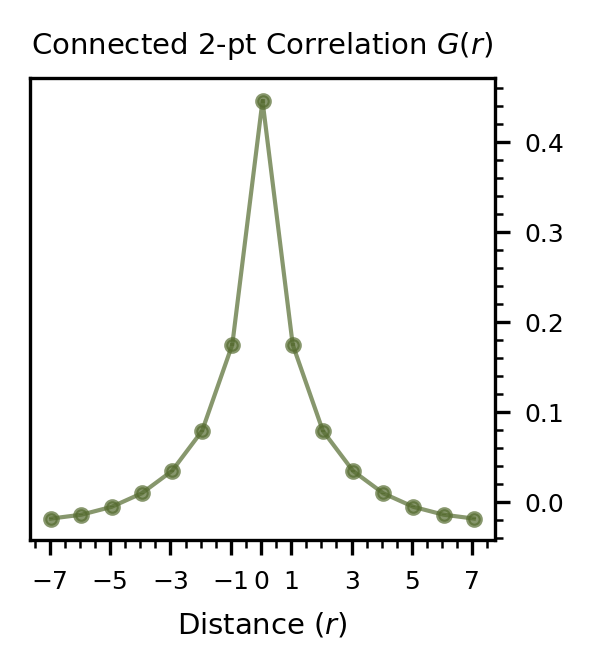

In [9]:


# ------------------
# (2) DEFINE COLORS
# ------------------
colors = {
    "depth3_raw": "#C19A6B",  # Warm ochre (golden-brown)
    "depth3_sm": "#A67245",   # Slightly darker sienna (richer ochre)

    "depth4_raw": "#A67245",  # Carrying over sienna for continuity
    "depth4_sm": "#814F2E",   # Burnt umber (deeper reddish-brown)

    "attn_raw": "#7D9FB8",    # Muted blue-gray (contrasting)
    "attn_sm": "#3B6A8C",     # Slate blue (deeper, yet harmonious)

    "ais": "#c8b0df",
    "truth": "#556B2F"
}

# ------------------
# (3) CREATE TOP-LEVEL FIGURE + 3-COLUMN GRIDSPEC
# ------------------
fig = plt.figure(figsize=(2, 2))  # total figure size (width, height)
# 3 columns: [ESS plot | 3 stacked hist differences | TPCF plot]
gs = fig.add_gridspec(nrows=1, ncols=1, width_ratios=[1], wspace=0.2)

# ------------------
# (6) RIGHT COLUMN: TPCF PLOT (new figure)
# ------------------
ax_tpcf = fig.add_subplot(gs[0, 0])

# Example: 3 lines with error bars
#   "Truth"    : colors["truth"]
#   "LEC depth 5" : colors["depth4_sm"]
#   "LEA"       : colors["attn_sm"]

r = np.arange(15)
L = len(r)
# ax_tpcf.errorbar(r, tpcf_conv_mean, yerr=tpcf_conv_err, 
#                  color=colors["depth4_sm"], label='LEC (depth 5)', fmt='s--', alpha = 0.9, markersize=3, linewidth = 1.5)
# ax_tpcf.errorbar(r, tpcf_attn_mean, yerr=tpcf_attn_err, 
#                  color=colors["attn_sm"], label='LEA', fmt='^:', alpha = 0.7, markersize=3, linewidth = 1.5)
# ax_tpcf.errorbar(r, tpcf_truth_mean, yerr=tpcf_truth_err, 
#                  color=colors["truth"], label='Truth', fmt='o-', alpha = 0.7, markersize=3, linewidth = 1.5)

offset = 0.05  # or any small shift relative to your data spacing

r =  np.arange(15) - 7

# ax_tpcf.errorbar(r - offset, tpcf_conv_mean, yerr=tpcf_conv_err, 
#                  color=colors["depth4_sm"], label='LEC (depth 5)',
#                  fmt='s--', alpha=0.9, markersize=3, linewidth=1.0)

# ax_tpcf.errorbar(r, tpcf_attn_mean, yerr=tpcf_attn_err, 
#                  color=colors["attn_sm"], label='LEA',
#                  fmt='^:', alpha=0.7, markersize=3, linewidth=1.0)

ax_tpcf.errorbar(r + offset, tpcf_glauber_mean, yerr=tpcf_glauber_err, 
                 color=colors["truth"], label='Truth',
                 fmt='o-', alpha=0.7, markersize=3, linewidth=1.0)

ax_tpcf.set_xlabel(r"Distance ($r$)", fontsize=7)
ax_tpcf.set_title(r"Connected 2-pt Correlation $G(r)$", fontsize=7)
# ax_tpcf.legend(fontsize=6)

ax_tpcf.yaxis.set_label_position("right")
ax_tpcf.yaxis.tick_right()

# Optionally, adjust layout for better spacing
ax_tpcf.spines['right'].set_visible(True)  # Make the right spine visible
# ax_tpcf.spines['left'].set_visible(False)  # Hide the left spine
ax_tpcf.set_xticks([-7, -5, -3, -1, 0, 1, 3, 5, 7])


###### LEGEND

# for lh in leg.legend_handles:
#     lh.set_alpha(1)
    
# for line in leg.get_lines():
#     line.set_linewidth(3)  # Adjust the linewidth

# plt.savefig("ising-stats.pdf", bbox_inches='tight')
plt.show()